# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_error

import warnings


## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

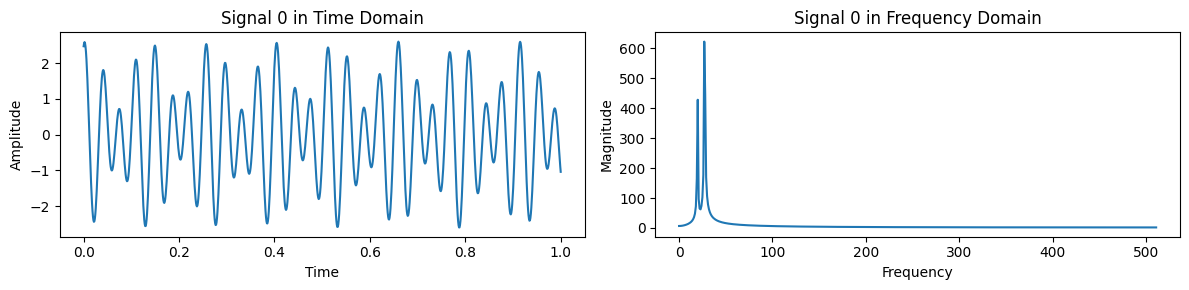

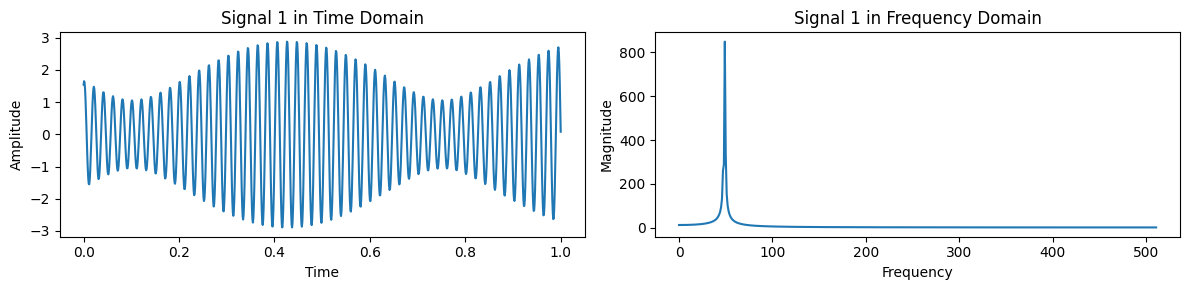

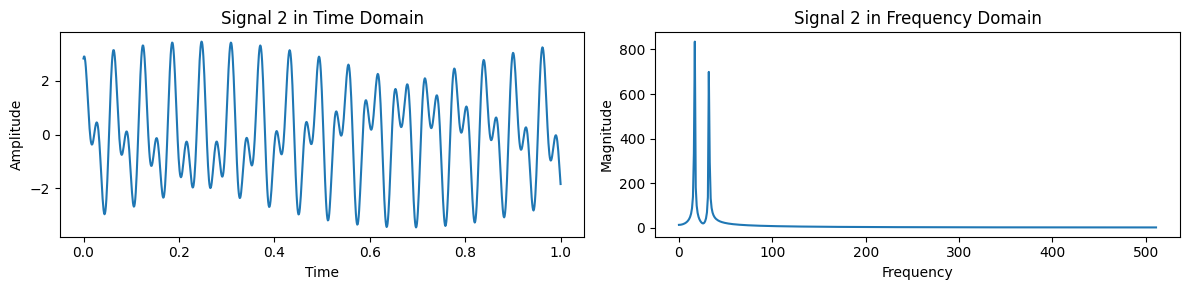

In [2]:
N = 1024
num_samples = 10000  # train
num_val = 2000  # val

def generate_signals_with_two_frequencies(num_samples, N):
    signals = []
    for _ in range(num_samples):
        time = np.linspace(0, 1, N)

        freq1 = np.random.uniform(5, 50)
        amplitude1 = np.random.uniform(0.5, 2.0)
        phase1 = np.random.uniform(0, 2 * np.pi)
        
        freq2 = np.random.uniform(5, 50)
        amplitude2 = np.random.uniform(0.5, 2.0)
        phase2 = np.random.uniform(0, 2 * np.pi)
        
        signal = (amplitude1 * np.sin(2 * np.pi * freq1 * time + phase1) +
                  amplitude2 * np.sin(2 * np.pi * freq2 * time + phase2))
        signals.append(signal)
    return np.array(signals)

signals = generate_signals_with_two_frequencies(num_samples + num_val, N)

fft_signals = np.fft.fft(signals)

X_train, X_val = train_test_split(fft_signals, test_size=num_val, random_state=42)

def plot_signals(signal, fft_signal, idx):
    time = np.linspace(0, 1, N)
    freq = np.fft.fftfreq(N, d=1/N)
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(time, signal)
    plt.title(f"Signal {idx} in Time Domain")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    plt.subplot(1, 2, 2)
    plt.plot(freq[:N//2], np.abs(fft_signal[:N//2]))
    plt.title(f"Signal {idx} in Frequency Domain")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    
    plt.tight_layout()
    plt.show()

for i in range(3):
    plot_signals(np.real(np.fft.ifft(X_train[i])), X_train[i], i)


### Соберите и обучите нейросетку на pyTroch для преобразования Фурье

In [3]:
N = 1024
num_samples = 10000
num_val = 2000
batch_size = 64
epochs = 20
learning_rate = 1e-3

signals = generate_signals_with_two_frequencies(num_samples + num_val, N)
fft_signals = np.fft.fft(signals)

X_train, X_val, y_train, y_val = train_test_split(
    signals, fft_signals, test_size=num_val, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(
    np.stack([np.real(y_train), np.imag(y_train)], axis=-1), dtype=torch.float32
)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(
    np.stack([np.real(y_val), np.imag(y_val)], axis=-1), dtype=torch.float32
)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class FourierApproximationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(FourierApproximationNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

model = FourierApproximationNet(input_size=N, output_size=N * 2)  # 2 компоненты (реальная и мнимая)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(X_batch.size(0), -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(X_batch.size(0), -1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20, Train Loss: 709.2099, Val Loss: 450.3430
Epoch 2/20, Train Loss: 282.5857, Val Loss: 181.3048
Epoch 3/20, Train Loss: 107.0004, Val Loss: 67.9889
Epoch 4/20, Train Loss: 46.1997, Val Loss: 43.5540
Epoch 5/20, Train Loss: 36.6375, Val Loss: 38.8282
Epoch 6/20, Train Loss: 32.6418, Val Loss: 35.7007
Epoch 7/20, Train Loss: 29.3035, Val Loss: 33.2585
Epoch 8/20, Train Loss: 25.3559, Val Loss: 28.5686
Epoch 9/20, Train Loss: 22.7505, Val Loss: 26.3111
Epoch 10/20, Train Loss: 21.2322, Val Loss: 25.5534
Epoch 11/20, Train Loss: 19.9519, Val Loss: 24.7481
Epoch 12/20, Train Loss: 19.0491, Val Loss: 22.9086
Epoch 13/20, Train Loss: 18.2344, Val Loss: 22.8286
Epoch 14/20, Train Loss: 17.4151, Val Loss: 22.6570
Epoch 15/20, Train Loss: 16.9464, Val Loss: 21.7048
Epoch 16/20, Train Loss: 16.2744, Val Loss: 21.6802
Epoch 17/20, Train Loss: 15.8758, Val Loss: 19.7815
Epoch 18/20, Train Loss: 15.0475, Val Loss: 19.4505
Epoch 19/20, Train Loss: 14.3994, Val Loss: 18.4551
Epoch 20/20, Tra

In [4]:
model.eval()
with torch.no_grad():
    sample_idx = 0
    prediction = model(X_val[sample_idx].unsqueeze(0)).view(N, 2)
    predicted_spectrum = prediction[:, 0] + 1j * prediction[:, 1]
    true_spectrum = y_val[sample_idx][:, 0] + 1j * y_val[sample_idx][:, 1]

### Сравните свое решение с пакетным методом

/var/folders/5n/x5mny29d1t16fq8lylrw5xn80000gn/T/ipykernel_60109/1095606936.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(freq[:N//2], np.abs(true_spectrum[:N//2]), label="True Spectrum")
/var/folders/5n/x5mny29d1t16fq8lylrw5xn80000gn/T/ipykernel_60109/1095606936.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(freq[:N//2], np.abs(predicted_spectrum[:N//2]), label="Predicted Spectrum", linestyle="dashed")


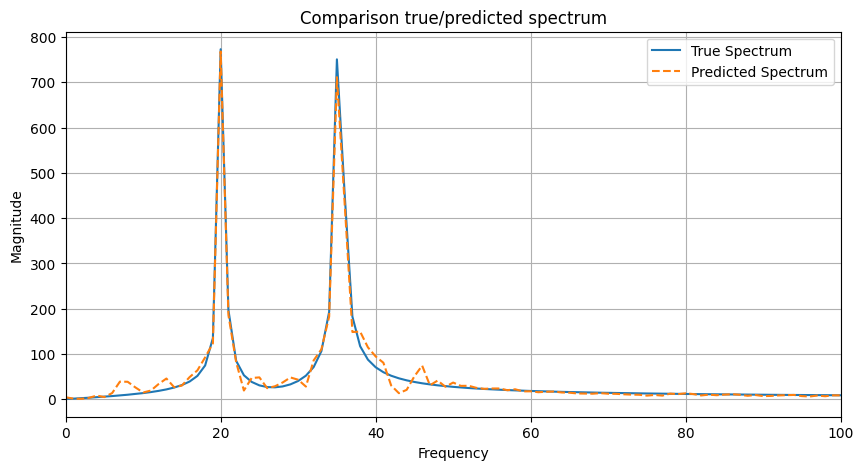

In [5]:
freq = np.fft.fftfreq(N, d=1/N)

plt.figure(figsize=(10, 5))
plt.plot(freq[:N//2], np.abs(true_spectrum[:N//2]), label="True Spectrum")
plt.plot(freq[:N//2], np.abs(predicted_spectrum[:N//2]), label="Predicted Spectrum", linestyle="dashed")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.title("Comparison true/predicted spectrum")
plt.xlim(0, 100)
plt.show()

In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

def compute_mse(true_spectrum, predicted_spectrum):
    return mean_squared_error(np.abs(true_spectrum), np.abs(predicted_spectrum))

def evaluate_mse(X_val, y_val, model):
    model.eval()
    total_samples = len(X_val)
    mse_nn_list, mse_pkg_list = [], []
    
    with torch.no_grad():
        for i in range(total_samples):
            true_spectrum = y_val[i][:, 0] + 1j * y_val[i][:, 1]
            
            nn_prediction = model(X_val[i].unsqueeze(0)).view(N, 2)
            predicted_spectrum_nn = nn_prediction[:, 0] + 1j * nn_prediction[:, 1]
            
            signal = X_val[i].numpy()
            predicted_spectrum_pkg = np.fft.fft(signal)
            
            mse_nn = compute_mse(true_spectrum, predicted_spectrum_nn)
            mse_pkg = compute_mse(true_spectrum, predicted_spectrum_pkg)
            
            mse_nn_list.append(mse_nn)
            mse_pkg_list.append(mse_pkg)
    
    avg_mse_nn = np.mean(mse_nn_list)
    avg_mse_pkg = np.mean(mse_pkg_list)
    return avg_mse_nn, avg_mse_pkg

avg_mse_nn, avg_mse_pkg = evaluate_mse(X_val, y_val, model)
print(f"MSE (NN): {avg_mse_nn:.6f}")
print(f"MSE (Package): {avg_mse_pkg:.6f}")


MSE (NN): 19.253206
MSE (Package): 0.000000


## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [27]:
N = 1024
num_samples = 10000
num_val = 2000
fs = 1.0

signals = generate_signals_with_two_frequencies(num_samples + num_val, N)

def compute_psd_db(signal, fs, nfft):
    freqs, psd = periodogram(signal, fs=fs, nfft=nfft)
    psd_db = 10 * np.log10(psd + 1e-12)
    return freqs, psd_db

psd_db_data = []
for signal in signals:
    _, psd_db = compute_psd_db(signal, fs, N)
    psd_db_data.append(psd_db)

psd_db_data = np.array(psd_db_data)

X_train, X_val = train_test_split(psd_db_data, test_size=num_val, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")


Train shape: torch.Size([10000, 513])
Val shape: torch.Size([2000, 513])


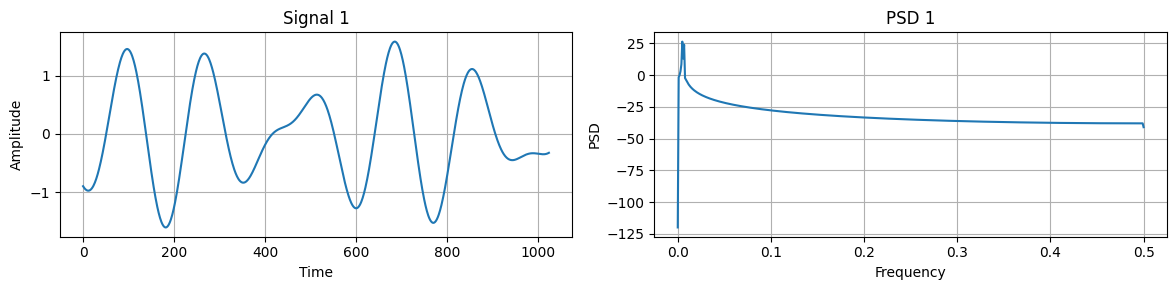

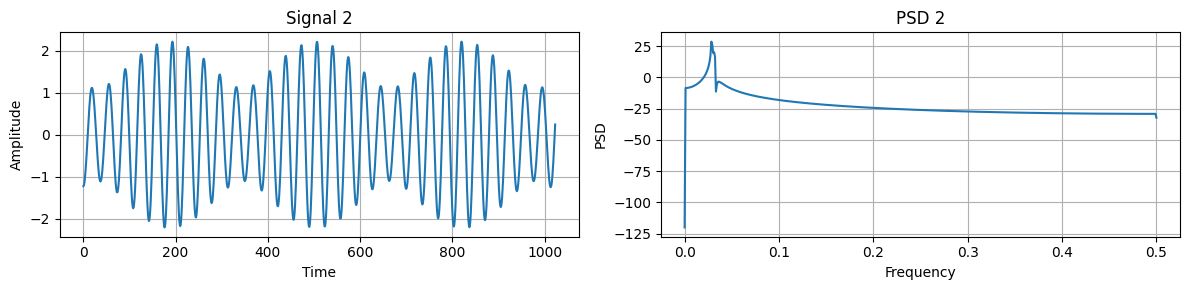

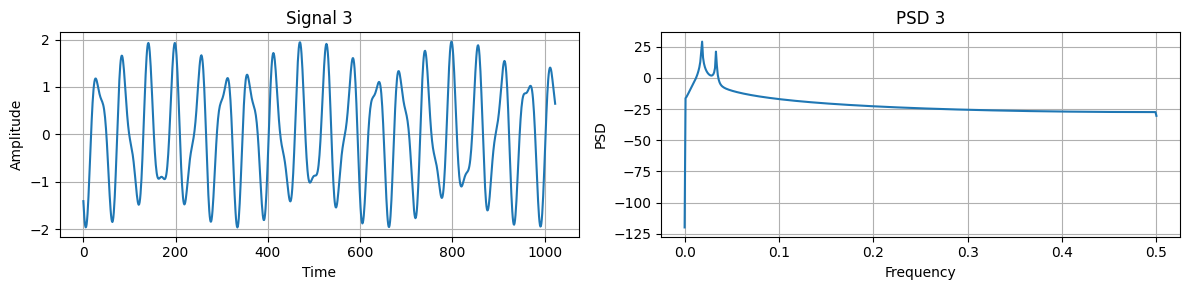

In [28]:
for i in range(3):
    signal = signals[i]
    psd_db = psd_db_data[i]
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(signal)
    plt.title(f"Signal {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(freqs, psd_db)
    plt.title(f"PSD {i + 1}")
    plt.xlabel("Frequency")
    plt.ylabel("PSD")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

In [29]:
input_size = 1024
output_size = 513 # periodogram возвращает N//2 + 1
batch_size = 64
epochs = 20
learning_rate = 1e-3

X_train = torch.tensor(signals[:num_samples], dtype=torch.float32)
y_train = torch.tensor(psd_db_data[:num_samples], dtype=torch.float32)
X_val = torch.tensor(signals[num_samples:], dtype=torch.float32)
y_val = torch.tensor(psd_db_data[num_samples:], dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class PSDPredictorNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PSDPredictorNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

model = PSDPredictorNet(input_size=input_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")


Epoch 1/20, Train Loss: 219.164318, Val Loss: 143.833457
Epoch 2/20, Train Loss: 134.120415, Val Loss: 140.499291
Epoch 3/20, Train Loss: 124.094311, Val Loss: 130.189665
Epoch 4/20, Train Loss: 116.990299, Val Loss: 127.407518
Epoch 5/20, Train Loss: 112.106420, Val Loss: 124.458860
Epoch 6/20, Train Loss: 108.785109, Val Loss: 122.810984
Epoch 7/20, Train Loss: 104.757302, Val Loss: 118.686898
Epoch 8/20, Train Loss: 100.659145, Val Loss: 115.210151
Epoch 9/20, Train Loss: 97.567842, Val Loss: 107.507360
Epoch 10/20, Train Loss: 89.987301, Val Loss: 98.898574
Epoch 11/20, Train Loss: 71.155538, Val Loss: 81.589576
Epoch 12/20, Train Loss: 56.584424, Val Loss: 61.768051
Epoch 13/20, Train Loss: 46.540228, Val Loss: 54.481811
Epoch 14/20, Train Loss: 39.003867, Val Loss: 48.257143
Epoch 15/20, Train Loss: 34.589308, Val Loss: 44.983325
Epoch 16/20, Train Loss: 30.332222, Val Loss: 43.350431
Epoch 17/20, Train Loss: 28.883656, Val Loss: 39.937052
Epoch 18/20, Train Loss: 24.468165, Val 

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

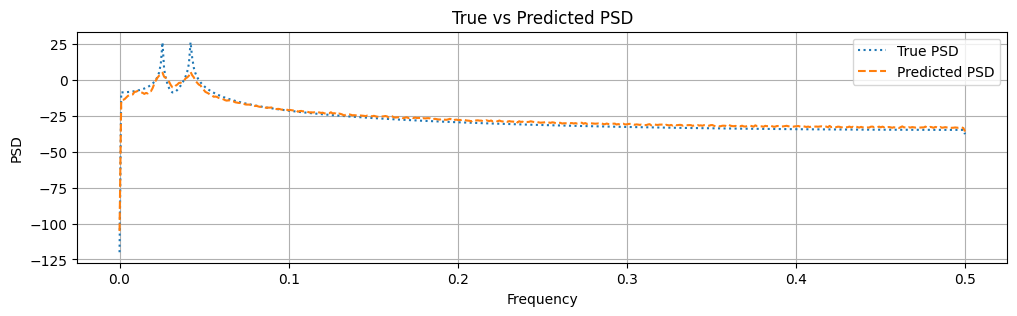

In [30]:
model.eval()
with torch.no_grad():
    sample_idx = 0
    prediction = model(X_val[sample_idx].unsqueeze(0)).numpy().flatten()
    true_psd = y_val[sample_idx].numpy()

freqs = np.fft.rfftfreq(input_size, d=1)

plt.figure(figsize=(12, 3))
plt.plot(freqs, true_psd, label="True PSD", linestyle="dotted")
plt.plot(freqs, prediction, label="Predicted PSD", linestyle="dashed")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.title("True vs Predicted PSD")
plt.legend()
plt.grid(True)
plt.show()